## Travel Startup

According to [Britannica's report](https://www.britannica.com/science/temperature-humidity-index), the formula of calculating the discomprt index is 15 + 0.4(dry-bulb temperature + web-bulb temperature(F)). However, in the NAM dataset wo do not have the air temperature(equals to dry-bulb temperature), we took the surface temperature as the dry-bulb(well, they are similar enough).

There are a lot of approaches to cacluate the wet-bulb temperature. The [How to calcylate the wet bulb temperature](https://www.omnicalculator.com/physics/wet-bulb#how-to-calculate-the-wet-bulb-temperature) gives us a straightfoward approach, by dry-bulb(Td) and relative humidity(rh), to simply obtain the wet-bulb-temperature(Tw).  
Tw = Td * arctan[0.151977 * (rh + 8.313659)^(1/2)] + arctan(Td + rh) - arctan(rh - 1.676331) + 0.00391838 *(rh)^(3/2) * arctan(0.023101 * rh) - 4.686035   

The Britannica's report also mentions *Most people are quite comfortable when the index is below 70 and very uncomfortable when the index is above 80 to 85*. However, when the index is below 40 may be too wet and cold to stay, and in order to pick up the most comfortable duration we decided to consider the index from 40 to 60 is comfortable, otherwise is uncomfortable.  



In [1]:
import math
def wetBuldCalculator(temp_celsius, rh):
    return temp_celsius \
    * math.atan(0.151977 * (rh + 8.313659)**(1/2)) \
    + math.atan(temp_celsius + rh) \
    - math.atan(rh - 1.676331) \
    + 0.00391838 * (rh)**(3/2) \
    * math.atan(0.023101 * rh) \
    - 4.686035

def confortIndex(dry_buld, rh):
    dry_buld_c = dry_buld - 273.15
    wet_buld_c = wetBuldCalculator(dry_buld_c, rh)
    ci = 15 + 0.4 * ((dry_buld_c + wet_buld_c) * (9.0 / 5.0) + 32)
    return ci



### Travel Location
We choose 5 five locations, which are San Francisco, Austin(Texas), Washington D.C, New York Cit, and Death Valley National Par(South California).  

In [2]:
# Five places
travel_locaions = {
    "9q8y" : "San Francisco",
    "9v6k" : "Austin",
    "dqcj" : "Washington D.C",
    "dr5r" : "New York City",
    "9qky" : "Death Valley National Park"
}

### Data filter
Our goal is to make a travel plan, so we need to pick reasonable data. People are usually hanging out during moring to evening. Therefore, we filter out the data from 0 am to 8 am where people will not be outside. 

In [3]:
text_file = sc.textFile("hdfs://orion11:12001/pj3/3hr/2019")
import datetime
import geohash

def parseLine(line):
    variables = line.split("\t")
    try:
        milliseconds = int(variables[0])
        dt = datetime.datetime.fromtimestamp(milliseconds/1000.0)
        # filter out hour between 0 to 8 (midnight to morning)
        if(dt.hour < 8):
            return ('', 0, 0)
        
        lat = float(variables[1])
        lon = float(variables[2])
        rh = float(variables[8])
        temperatureK = float(variables[10])
        
        gh = geohash.encode(lat, lon)[0:4]
        if gh in travel_locaions:
            ci = confortIndex(temperatureK, rh)
            return (gh, dt.month, ci)
        else: 
            return ('', 0, 0)
    except:
        return ('', 0, 0)

parsed_data = text_file \
    .map(lambda line: parseLine(line)) \
    .filter(lambda val : val[0] != '')


travel_location_ci = {}

def avg_comfort_index(indecis):
    result = []
    for month in indecis:
        count = 0
        ci_sum = 0
        for ci in month[1]:
            count += 1
            ci_sum += ci
        result.append((month[0], ci_sum/count))
    return result
    

for gh in travel_locaions:
    month_ci_goruped = parsed_data.filter(lambda data: data[0] == gh)\
                .map(lambda data: (data[1], data[2]))\
                .groupByKey()
    travel_location_ci[travel_locaions[gh]] = avg_comfort_index(month_ci_goruped.collect())


In [7]:
# Prepare data to output
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
locations = list(travel_locaions.values())
all_locations_month_avg_ci = []
# Output data to a 2D array, 
for location in locations:
    month_ci = []
    for lc in travel_location_ci[location]:
        month_ci.append(int(lc[1]))
    all_locations_month_avg_ci.append(month_ci)

### Display
In order to display the overall distruibution of comfort index for each place, the following code is refered to the [Matplotlib tutorial](https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py), it helps us to make a clear diagram. 

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

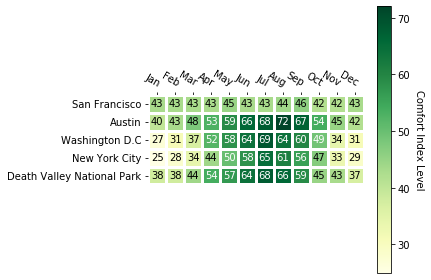

In [6]:
data = np.array(all_locations_month_avg_ci)
fig, ax = plt.subplots()
im, cbar = heatmap(data, locations, months, ax=ax,
                   cmap="YlGn", cbarlabel="Comfort Index Level")
texts = annotate_heatmap(im, valfmt="{x:2d}")

fig.tight_layout()
plt.show()

### Conclusion
According to the chart above, we see most of the locations would be quite uncomfortable during summer time. The temperature and humidity are quite the same in San Francisco. Austin is really hot, iw would be great to visit during November to March. Washington D.C and New York City has similar indecis, October and April is a perfect time to go. Finally, we picked Death Valley National Park because it said that is the hottest place in the US. However, during the winter time is seems like other places. 